# Conditional Gaussian KDE
Here we go through a simple example of a conditional Gaussian KDE.
Let's imagine we would like to sample from the distribution $P(x|y)$, given that samples from a full distribution $P(x, y)$ are available. Example of such scenario could be an MCMC chain, fitted for both $x$ and $y$.

In general, such procedure is not possible as one would need to run MCMC from beginning, by sampling $P(x|y)$ directly, for one particular $y$. However, if we make an analytical form of the total pdf, then in principle we could obtain such conditional distribution for any $y$.

`ConditionalGaussianKernelDensity` class implements these functionalities:

- fitting the Gaussian KDE for the total distribution $P(x, y)$ form its samples,
- slicing through it to either obtain samples of the $P(x | y)$, or calculate the exact values of the conditional probability.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from conditional_kde import ConditionalGaussianKernelDensity

As an example, let's create a simple 2D sample of points and fit KDE with it.

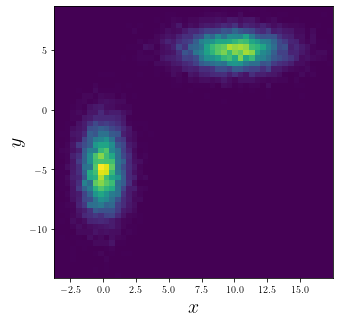

In [2]:
mean1, cov1 = [0, -5], [[1, 0], [0, 5]]
mean2, cov2 = [10, 5], [[5, 0], [0, 1]]
data_xy = np.concatenate(
    (
        np.random.multivariate_normal(mean1, cov1, 10000), 
        np.random.multivariate_normal(mean2, cov2, 10000)
    ), 
    axis = 0
)
data_y = data_xy[:, 1, np.newaxis]
plt.figure(figsize = (5, 5))
plt.hist2d(data_xy[:, 0], data_xy[:, 1], bins = 50)
plt.xlabel("$x$", fontsize = 20)
plt.ylabel("$y$", fontsize = 20);

In [3]:
kde = ConditionalGaussianKernelDensity(whitening_algorithm = "rescale")
kde.fit(data_xy, features = ["x", "y"])

Now we can either pull samples for some conditional values of y, or calculate analytical distributions for it.

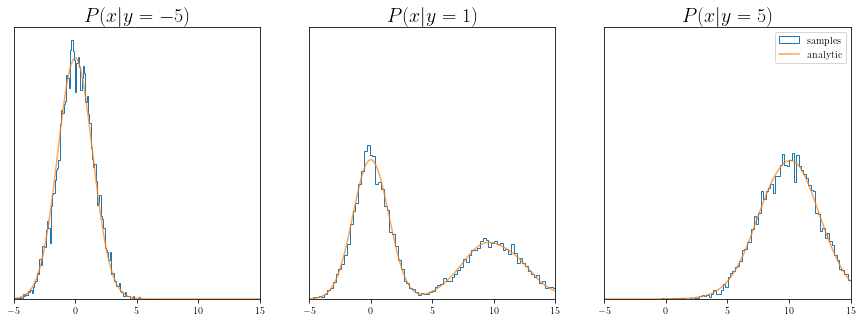

In [4]:
mini, maxi = -5, 15
X = np.linspace(mini, maxi, 100)
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (15, 5))

for y, ax in zip([-5, 1, 5], axes):
    # pulling conditional samples
    data_x_cond_y = kde.sample(
        conditionals = {"y": y},
        n_samples = 10000,
        keep_dims = False,
    )
    # plotting histogram
    ax.hist(
        data_x_cond_y, 
        bins = 100, 
        density = True, 
        label = "samples", 
        histtype = "step",
    )
    
    # calculating analytical probabilities along the axis
    x = np.stack([X, np.ones(len(X)) * y], axis = -1)
    probs = np.exp(kde.score_samples(x, conditional_features = ["y"]))
    # plotting the function
    ax.plot(X, probs, label = "analytic", alpha = 0.7)

    ax.set_title(f"$P(x | y = {y})$", fontsize = 20)
    ax.set_xlim((mini, maxi))
    ax.set_yticks([])
    ax.set_xticks([-5, 0, 5, 10, 15])
plt.legend();

## ZCA whitening
Instead of a simple rescale of dimensions, potentionally more powerful whitening can be obtained with ZCA algorithm. It scales the data along the principal axis. The method comes with a bit bigger computational overhead. Here we show results for the same example as before.

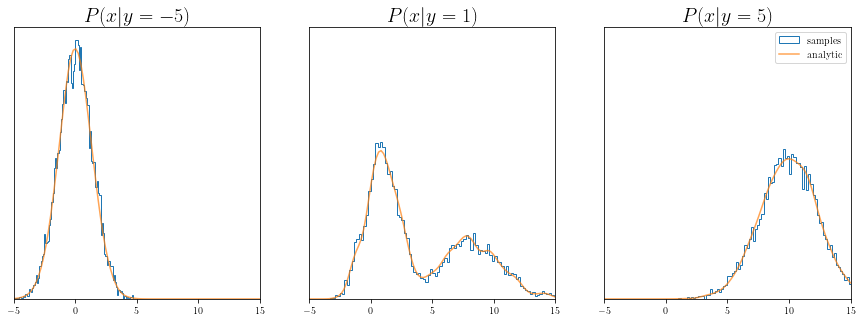

In [5]:
kde = ConditionalGaussianKernelDensity(whitening_algorithm = "ZCA")
kde.fit(data_xy, features = ["x", "y"])

mini, maxi = -5, 15
X = np.linspace(mini, maxi, 100)
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (15, 5))

for y, ax in zip([-5, 1, 5], axes):
    # pulling conditional samples
    data_x_cond_y = kde.sample(
        conditionals = {"y": y},
        n_samples = 10000,
        keep_dims = False,
    )
    # plotting histogram
    ax.hist(
        data_x_cond_y, 
        bins = 100, 
        density = True, 
        label = "samples", 
        histtype = "step",
    )
    
    # calculating analytical probabilities along the axis
    x = np.stack([X, np.ones(len(X)) * y], axis = -1)
    probs = np.exp(kde.score_samples(x, conditional_features = ["y"]))
    # plotting the function
    ax.plot(X, probs, label = "analytic", alpha = 0.7)

    ax.set_title(f"$P(x | y = {y})$", fontsize = 20)
    ax.set_xlim((mini, maxi))
    ax.set_yticks([])
    ax.set_xticks([-5, 0, 5, 10, 15])
plt.legend();